In [1]:
# Environment Setup
!pip uninstall -y torch torchvision torchaudio
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121
!pip install -U transformers accelerate bitsandbytes datasets scipy matplotlib pandas tqdm wandb

import torch
import torch.nn as nn
import torch.nn.functional as F
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig
from datasets import load_dataset, concatenate_datasets
from tqdm.notebook import tqdm
import pandas as pd
import numpy as np
import copy
import gc
import wandb
import time

# Verify Hardware
print(f"PyTorch: {torch.__version__}")
try:
    _ = torch.float8_e4m3fn
    print("✅ Hardware Ready: Native FP8 Supported.")
except AttributeError:
    raise RuntimeError("❌ Error: FP8 not supported. Use L4 or A100 GPU.")

device = "cuda"

Found existing installation: torch 2.5.1+cu121
Uninstalling torch-2.5.1+cu121:
  Successfully uninstalled torch-2.5.1+cu121
Found existing installation: torchvision 0.20.1+cu121
Uninstalling torchvision-0.20.1+cu121:
  Successfully uninstalled torchvision-0.20.1+cu121
Found existing installation: torchaudio 2.5.1+cu121
Uninstalling torchaudio-2.5.1+cu121:
  Successfully uninstalled torchaudio-2.5.1+cu121
Looking in indexes: https://download.pytorch.org/whl/cu121
  Using cached https://download.pytorch.org/whl/cu121/torch-2.5.1%2Bcu121-cp312-cp312-linux_x86_64.whl (780.4 MB)
  Using cached https://download.pytorch.org/whl/cu121/torchvision-0.20.1%2Bcu121-cp312-cp312-linux_x86_64.whl (7.3 MB)
  Using cached https://download.pytorch.org/whl/cu121/torchaudio-2.5.1%2Bcu121-cp312-cp312-linux_x86_64.whl (3.4 MB)
PyTorch: 2.5.1+cu121
✅ Hardware Ready: Native FP8 Supported.


In [2]:
# Set for reproducibility
import random
import numpy as np
from transformers import set_seed

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
set_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

## **Configuration & Experiment Controls**

In [3]:
# --- Experiment Settings ---
MODELS_TO_TEST = ["Qwen/Qwen2.5-1.5B-Instruct"]
SENSITIVITY_THRESHOLDS = [0.0, 0.05, 0.1, 0.2, 0.3]
CALIBRATION_SAMPLES = 128
EVAL_SAMPLES = 5000
WANDB_PROJECT_NAME = "KLD_Quantization_FP4_vs_FP8"

In [4]:
import wandb
import pandas as pd
from datasets import load_dataset, concatenate_datasets
import os
os.environ["WANDB_QUIET"] = "true"

wandb.login()

if 'results_table' not in globals():
    results_table = []

print("Loading MMLU Dataset...")
try:
    mmlu_dataset = concatenate_datasets([
        load_dataset("cais/mmlu", "all", split='test')
    ])
    print(f"MMLU Dataset Loaded. Size: {len(mmlu_dataset)} samples.")
except Exception as e:
    print(f"Error loading MMLU: {e}")
    from datasets import Dataset
    mmlu_dataset = Dataset.from_dict({
        "question": ["1+1=?"], "choices": [["1", "2", "3", "4"]], "answer": [1]
    })

print("Global setup complete. Ready for Step 2.")

wandb: (1) Create a W&B account
wandb: (2) Use an existing W&B account
wandb: (3) Don't visualize my results
wandb: Enter your choice:

 2


wandb: You chose 'Use an existing W&B account'
wandb: Logging into https://api.wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: Find your API key here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: yq171014 (yq171014-columbia-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Loading MMLU Dataset...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

dataset_infos.json: 0.00B [00:00, ?B/s]

all/test-00000-of-00001.parquet:   0%|          | 0.00/3.50M [00:00<?, ?B/s]

all/validation-00000-of-00001.parquet:   0%|          | 0.00/408k [00:00<?, ?B/s]

all/dev-00000-of-00001.parquet:   0%|          | 0.00/76.5k [00:00<?, ?B/s]

all/auxiliary_train-00000-of-00001.parqu(…):   0%|          | 0.00/47.5M [00:00<?, ?B/s]

Generating test split:   0%|          | 0/14042 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1531 [00:00<?, ? examples/s]

Generating dev split:   0%|          | 0/285 [00:00<?, ? examples/s]

Generating auxiliary_train split:   0%|          | 0/99842 [00:00<?, ? examples/s]

MMLU Dataset Loaded. Size: 14042 samples.
Global setup complete. Ready for Step 2.


## **Metrics & Helper Functions**

In [5]:
def recursive_getattr(obj, attr):
    for part in attr.split('.'):
        obj = getattr(obj, part)
    return obj

def recursive_setattr(obj, attr, val):
    pre, _, post = attr.rpartition('.')
    parent = recursive_getattr(obj, pre) if pre else obj
    setattr(parent, post, val)

In [6]:
# --- Metrics Helpers ---
def compute_kld(logits_p, logits_q):
    p_probs = F.softmax(logits_p, dim=-1)
    q_log_probs = F.log_softmax(logits_q, dim=-1)
    return nn.KLDivLoss(reduction='batchmean')(q_log_probs, p_probs).item()

def calculate_flip_rate(base_preds, new_preds):
    """Calculates % of answers that changed from the baseline."""
    if not base_preds or not new_preds: return 0.0
    flips = sum([1 for b, n in zip(base_preds, new_preds) if b != n])
    return flips / len(base_preds)

def compute_perplexity(model, tokenizer):
    """Computes perplexity on a subset of WikiText-2"""
    encodings = tokenizer("\n\n".join(load_dataset("wikitext", "wikitext-2-raw-v1", split="test")["text"][:20]), return_tensors="pt")
    max_length = model.config.max_position_embeddings
    stride = 512
    seq_len = encodings.input_ids.size(1)

    nlls = []
    prev_end_loc = 0
    for begin_loc in tqdm(range(0, seq_len, stride), desc="Computing PPL"):
        end_loc = min(begin_loc + max_length, seq_len)
        trg_len = end_loc - prev_end_loc
        input_ids = encodings.input_ids[:, begin_loc:end_loc].to(device)
        target_ids = input_ids.clone()
        target_ids[:, :-trg_len] = -100

        with torch.no_grad():
            outputs = model(input_ids, labels=target_ids)
            nlls.append(outputs.loss)

        prev_end_loc = end_loc
        if end_loc == seq_len: break

    return torch.exp(torch.stack(nlls).mean()).item()

# def measure_efficiency(model, tokenizer, input_text="Hello world"):
#     """Measures Inference Latency and Peak VRAM Usage"""
#     input_ids = tokenizer(input_text, return_tensors="pt").to(device)
#     torch.cuda.empty_cache()
#     torch.cuda.reset_peak_memory_stats()

#     start_time = time.time()
#     with torch.no_grad():
#         # Generate 50 tokens to average out overhead
#         _ = model.generate(**input_ids, max_new_tokens=50, min_new_tokens=50)
#     end_time = time.time()

#     peak_mem = torch.cuda.max_memory_allocated() / 1024**3 # GB
#     latency = (end_time - start_time) # Seconds
#     return latency, peak_mem

def measure_efficiency(model, tokenizer, input_text="Hello world"):
    # 1. Cleanup
    gc.collect()
    torch.cuda.empty_cache()
    torch.cuda.reset_peak_memory_stats()
    torch.cuda.synchronize()

    # 2. Measure Static Memory (Model Weights Only)
    # This shows the pure effect of quantization storage
    static_mem_bytes = torch.cuda.memory_allocated()
    static_mem_gb = static_mem_bytes / 1024**3

    # 3. Run Inference
    input_ids = tokenizer(input_text, return_tensors="pt").to(device)
    start_time = time.time()
    with torch.no_grad():
        _ = model.generate(**input_ids, max_new_tokens=50, min_new_tokens=50)
    torch.cuda.synchronize()
    end_time = time.time()

    # 4. Measure Peak Memory (Weights + KV Cache + Temp Buffers)
    # This shows the "True Cost" to run the model
    peak_mem_bytes = torch.cuda.max_memory_allocated()
    peak_mem_gb = peak_mem_bytes / 1024**3

    latency = end_time - start_time

    return latency, static_mem_gb, peak_mem_gb

def evaluate_full_suite(model, tokenizer, dataset, metric_name):
    """Runs all metrics and returns them."""
    print(f"--- Evaluating: {metric_name} ---")

    # 1. Accuracy
    preds, truths = get_mmlu_predictions(model, dataset, EVAL_SAMPLES)
    acc = sum([1 for p, g in zip(preds, truths) if p == g]) / len(truths)

    # 2. Perplexity
    ppl = compute_perplexity(model, tokenizer)

    # 3. Efficiency (Unpack 3 values now)
    lat, static_mem, peak_mem = measure_efficiency(model, tokenizer)

    print(f"Results -> Acc: {acc:.2%}, PPL: {ppl:.2f}, Latency: {lat:.2f}s, Static Mem: {static_mem:.2f}GB, Peak Mem: {peak_mem:.2f}GB")

    # Return separate memory metrics
    return acc, ppl, lat, static_mem, peak_mem, preds

In [7]:
# --- MMLU Logic ---
def format_mmlu_prompt(example):
    options = [f"{label}. {example['choices'][i]}" for i, label in enumerate(['A', 'B', 'C', 'D'])]
    prompt_text = f"Question: {example['question']}\nOptions:\n" + "\n".join(options) + "\nAnswer:"
    messages = [
        {"role": "system", "content": "Output only the single letter (A, B, C, or D) corresponding to the correct answer."},
        {"role": "user", "content": prompt_text}
    ]
    return tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)

def get_mmlu_predictions(model, dataset, num_samples):
    predictions, ground_truths = [], []
    choices = ["A", "B", "C", "D"]
    choice_ids = [tokenizer.encode(c)[0] for c in choices]

    for i in tqdm(range(min(num_samples, len(dataset))), desc="MMLU Eval"):
        ex = dataset[i]
        inputs = tokenizer(format_mmlu_prompt(ex), return_tensors="pt").to(device)
        with torch.no_grad():
            outputs = model(**inputs)
            logits = outputs.logits[0, -1, choice_ids]
            pred = choices[torch.argmax(logits).item()]
        predictions.append(pred)
        ground_truths.append(choices[ex['answer']])
    return predictions, ground_truths

## **Advanced Sensitivity Profiling**

In [8]:
def profile_restoration_sensitivity(model_q, model_ref, calib_input, granularity='layer'):
    """
    Profiles sensitivity by measuring the KLD improvement when restoring
    individual parts of the quantized model (model_q) back to FP16 (model_ref).

    Returns:
        sensitivity_scores: Dict mapping name -> KLD improvement (Higher is more sensitive).
    """
    print(f"Profiling Restoration Sensitivity (Granularity: {granularity})...")

    # Compute Baseline
    model_ref.eval()

    with torch.no_grad():
        ref_device = next(model_ref.parameters()).device
        base_logits = model_ref(calib_input.to(ref_device)).logits.to(device)
        current_logits = model_q(calib_input.to(device)).logits
        initial_kld = compute_kld(base_logits, current_logits)

    print(f"Initial Quantized KLD: {initial_kld:.6f}")

    sensitivity_scores = {}

    def get_module_by_name(module, access_string):
        names = access_string.split(sep='.')
        return reduce(getattr, names, module)

    from functools import reduce

    # Block-wise or Layer-wise
    if granularity == 'block':
        if hasattr(model_q, 'model') and hasattr(model_q.model, 'layers'):
            iterable_items = list(enumerate(model_q.model.layers))
            prefix = "model.model.layers"
        else:
            raise ValueError("Could not detect transformer blocks structure.")
        iterator = tqdm(iterable_items, desc="Profiling Blocks")
    elif granularity == 'layer':
        # # We limit this to just the linear layers to save time
        # iterable_items = [(n, m) for n, m in model_q.named_modules() if isinstance(m, (nn.Linear,  import_bnb_linear_type_if_needed()))]
        iterable_items = [(n, m) for n, m in model_q.named_modules()
                          if "mlp" in n or "self_attn" in n]
        iterator = tqdm(iterable_items, desc="Profiling Layers")

    # Restoration Loop
    for name_or_idx, module_q in iterator:
        target_name = f"{prefix}.{name_or_idx}" if granularity == 'block' else name_or_idx
        try:
            module_ref = recursive_getattr(model_ref, target_name)
            backup_quant_module = recursive_getattr(model_q, target_name)
            module_fp16_gpu = copy.deepcopy(module_ref).to(device)
            recursive_setattr(model_q, target_name, module_fp16_gpu)

            # Measure New KLD
            with torch.no_grad():
                new_logits = model_q(calib_input.to(device)).logits
                new_kld = compute_kld(base_logits, new_logits)

            improvement = initial_kld - new_kld
            sensitivity_scores[target_name] = improvement
            recursive_setattr(model_q, target_name, backup_quant_module)

            # Cleanup VRAM
            del module_fp16_gpu

        except Exception as e:
            print(f"Skipping {target_name}: {e}")

    return sensitivity_scores

## **The "Surgery" Implementation**

In [9]:
def perform_surgery(model, sensitive_names, fp16_model_cpu):
    """
    Replaces the sensitive quantized layers in 'model' (GPU)
    with the original FP16 layers from 'fp16_model_cpu' (CPU).

    This Generic Version uses deepcopy, so it works for:
    - Individual Linear layers (gate_proj, q_proj)
    - Entire Blocks (Qwen2MLP, Qwen2Attention)
    """
    count = 0
    print(f"Surgery: Replacing {len(sensitive_names)} Sensitive Layers with FP16...")

    for name in sensitive_names:
        try:
            # 1. Get original FP16 module from CPU backup
            #    (This handles Linear, Qwen2MLP, Qwen2Attention, etc.)
            original_module = recursive_getattr(fp16_model_cpu, name)

            # 2. Create a deep copy and move to GPU
            #    We use deepcopy instead of manually instantiating nn.Linear.
            #    This preserves the exact class type and configuration.
            module_fp16_gpu = copy.deepcopy(original_module).to(model.device)

            # 3. Swap into the quantized model
            recursive_setattr(model, name, module_fp16_gpu)

            count += 1

        except Exception as e:
            print(f"Skipping layer {name}: {e}")

    print(f"Surgery Complete: {count} layers restored.")

# Model Selection & Baseline Evaluation

In [10]:

# Select model
CURRENT_MODEL_ID = MODELS_TO_TEST[0]

print(f"{'='*40}\nSelected Model: {CURRENT_MODEL_ID}\n{'='*40}")

tokenizer = AutoTokenizer.from_pretrained(CURRENT_MODEL_ID)
print("Loading FP16 Baseline (This may take a minute)...")
model_fp16 = AutoModelForCausalLM.from_pretrained(
    CURRENT_MODEL_ID,
    dtype=torch.float16,
    device_map="auto",
    trust_remote_code=True
)

# Evaluate Baseline
base_acc, base_ppl, base_lat, base_static_mem, base_peak_mem, base_preds = evaluate_full_suite(
    model_fp16, tokenizer, mmlu_dataset, "FP16 Baseline"
)

# Log Baseline to WandB
run = wandb.init(project=WANDB_PROJECT_NAME, name=f"{CURRENT_MODEL_ID.split('/')[-1]}-Baseline", reinit=True)
wandb.log({
    "Accuracy": base_acc,
    "Perplexity": base_ppl,
    "Latency": base_lat,
    "Static_Memory": base_static_mem,
    "Peak_Memory": base_peak_mem,
    "Threshold": 0,
    "Flip_Rate": 0.0,
    "Method": "Baseline"
})
run.finish()

# Store in Results Table
results_table.append({
    "Model": CURRENT_MODEL_ID,
    "Method": "FP16 Baseline",
    "Threshold": 0,
    "Acc": base_acc,
    "Flip": 0.0,
    "PPL": base_ppl,
    "Latency": base_lat,
    "Static Mem": base_static_mem,
    "Peak Mem": base_peak_mem
})

print("Baseline Loaded & Evaluated.")

Selected Model: Qwen/Qwen2.5-1.5B-Instruct


tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

Loading FP16 Baseline (This may take a minute)...


config.json:   0%|          | 0.00/660 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/3.09G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/242 [00:00<?, ?B/s]

--- Evaluating: FP16 Baseline ---


MMLU Eval:   0%|          | 0/5000 [00:00<?, ?it/s]

README.md: 0.00B [00:00, ?B/s]

wikitext-2-raw-v1/test-00000-of-00001.pa(…):   0%|          | 0.00/733k [00:00<?, ?B/s]

wikitext-2-raw-v1/train-00000-of-00001.p(…):   0%|          | 0.00/6.36M [00:00<?, ?B/s]

wikitext-2-raw-v1/validation-00000-of-00(…):   0%|          | 0.00/657k [00:00<?, ?B/s]

Generating test split:   0%|          | 0/4358 [00:00<?, ? examples/s]

Generating train split:   0%|          | 0/36718 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/3760 [00:00<?, ? examples/s]

Computing PPL:   0%|          | 0/3 [00:00<?, ?it/s]

Results -> Acc: 57.34%, PPL: 6.33, Latency: 1.87s, Static Mem: 2.88GB, Peak Mem: 2.89GB


wandb: WARNING Using a boolean value for 'reinit' is deprecated. Use 'return_previous' or 'finish_previous' instead.


Baseline Loaded & Evaluated.


In [11]:
# Profiling & Offloading
print("Preparing Calibration Data...")
calib_data = tokenizer(
    "\n\n".join(load_dataset("wikitext", "wikitext-2-raw-v1", split="test")["text"][:10]),
    return_tensors="pt"
).input_ids.to(device)

granularity_mode = 'layer'

# Offload FP16 Model to CPU to save memory
print("Moving FP16 model to CPU to free up VRAM...")
model_fp16.cpu()
torch.cuda.empty_cache()
print("VRAM Cleared. Ready for Experiments.")

Preparing Calibration Data...
Moving FP16 model to CPU to free up VRAM...
VRAM Cleared. Ready for Experiments.


# Experiments

In [12]:
# Experiment A: NF4

print(f"\n--- Starting Experiment A: NF4 {CURRENT_MODEL_ID} ---")

print("Loading NF4 Model for Profiling & Incremental Surgery...")
model_nf4 = AutoModelForCausalLM.from_pretrained(
    CURRENT_MODEL_ID,
    quantization_config=BitsAndBytesConfig(
        load_in_4bit=True,
        bnb_4bit_quant_type="nf4",
        bnb_4bit_compute_dtype=torch.float16
    ),
    device_map="auto",
    torch_dtype=torch.float16,
    trust_remote_code=True
)

sensitivity_map = profile_restoration_sensitivity(
    model_q=model_nf4,
    model_ref=model_fp16,
    calib_input=calib_data,
    granularity='layer'
)
sorted_layers = sorted(sensitivity_map.items(), key=lambda x: x[1], reverse=True)
all_layer_names = [n for n, s in sorted_layers]

# Experiment loop
sorted_thresholds = sorted(SENSITIVITY_THRESHOLDS)
current_restored_count = 0

for threshold in sorted_thresholds:
    print(f"\nTargeting Threshold: {threshold:.0%} kept in FP16")

    target_count = int(len(all_layer_names) * threshold)

    layers_to_fix_now = all_layer_names[current_restored_count : target_count]

    if layers_to_fix_now:
        print(f"Restoring {len(layers_to_fix_now)} additional layers...")
        perform_surgery(model_nf4, layers_to_fix_now, model_fp16)
        current_restored_count = target_count
    else:
        print("No new layers to restore for this step.")

    run = wandb.init(
        project=WANDB_PROJECT_NAME,
        name=f"{CURRENT_MODEL_ID.split('/')[-1]}-NF4-{threshold}",
        config={"model": CURRENT_MODEL_ID, "threshold": threshold, "method": "KLD-NF4"},
        reinit=True
    )

    acc, ppl, lat, static_mem, peak_mem, preds = evaluate_full_suite(
        model_nf4, tokenizer, mmlu_dataset, f"KLD-NF4-{threshold}"
    )

    flip = calculate_flip_rate(base_preds, preds)

    wandb.log({
        "Accuracy": acc, "Perplexity": ppl, "Latency": lat, "Static_Memory": static_mem,
        "Peak_Memory": peak_mem, "Flip_Rate": flip, "Threshold": threshold
    })

    results_table.append({
        "Model": CURRENT_MODEL_ID,
        "Method": "KLD-NF4",
        "Threshold": threshold,
        "Acc": acc,
        "Flip": flip,
        "PPL": ppl,
        "Latency": lat,
        "Static Mem": static_mem,
        "Peak Mem": peak_mem
    })

    run.finish()

# Cleanup
del model_nf4
torch.cuda.empty_cache()
print("Experiment A Complete.")


--- Starting Experiment A: NF4 Qwen/Qwen2.5-1.5B-Instruct ---
Loading NF4 Model for Profiling & Incremental Surgery...


`torch_dtype` is deprecated! Use `dtype` instead!


Profiling Restoration Sensitivity (Granularity: layer)...
Initial Quantized KLD: 49.968750


Profiling Layers:   0%|          | 0/280 [00:00<?, ?it/s]


Targeting Threshold: 0% kept in FP16
No new layers to restore for this step.


--- Evaluating: KLD-NF4-0.0 ---


MMLU Eval:   0%|          | 0/5000 [00:00<?, ?it/s]

Computing PPL:   0%|          | 0/3 [00:00<?, ?it/s]

Results -> Acc: 53.66%, PPL: 6.57, Latency: 2.60s, Static Mem: 1.14GB, Peak Mem: 1.17GB



Targeting Threshold: 5% kept in FP16
Restoring 14 additional layers...
Surgery: Replacing 14 Sensitive Layers with FP16...
Surgery Complete: 14 layers restored.


--- Evaluating: KLD-NF4-0.05 ---


MMLU Eval:   0%|          | 0/5000 [00:00<?, ?it/s]

Computing PPL:   0%|          | 0/3 [00:00<?, ?it/s]

Results -> Acc: 52.98%, PPL: 6.51, Latency: 2.46s, Static Mem: 1.65GB, Peak Mem: 1.67GB



Targeting Threshold: 10% kept in FP16
Restoring 14 additional layers...
Surgery: Replacing 14 Sensitive Layers with FP16...
Surgery Complete: 14 layers restored.


--- Evaluating: KLD-NF4-0.1 ---


MMLU Eval:   0%|          | 0/5000 [00:00<?, ?it/s]

Computing PPL:   0%|          | 0/3 [00:00<?, ?it/s]

Results -> Acc: 53.08%, PPL: 6.49, Latency: 2.48s, Static Mem: 1.78GB, Peak Mem: 1.80GB



Targeting Threshold: 20% kept in FP16
Restoring 28 additional layers...
Surgery: Replacing 28 Sensitive Layers with FP16...
Surgery Complete: 28 layers restored.


--- Evaluating: KLD-NF4-0.2 ---


MMLU Eval:   0%|          | 0/5000 [00:00<?, ?it/s]

Computing PPL:   0%|          | 0/3 [00:00<?, ?it/s]

Results -> Acc: 54.74%, PPL: 6.41, Latency: 2.23s, Static Mem: 2.43GB, Peak Mem: 2.45GB



Targeting Threshold: 30% kept in FP16
Restoring 28 additional layers...
Surgery: Replacing 28 Sensitive Layers with FP16...
Surgery Complete: 28 layers restored.


--- Evaluating: KLD-NF4-0.3 ---


MMLU Eval:   0%|          | 0/5000 [00:00<?, ?it/s]

Computing PPL:   0%|          | 0/3 [00:00<?, ?it/s]

Results -> Acc: 55.44%, PPL: 6.42, Latency: 2.15s, Static Mem: 2.52GB, Peak Mem: 2.55GB


Experiment A Complete.


=== Top 10 Most Sensitive Layers ===
                        Layer_Name  KLD_Gain
275            model.layers.27.mlp   5.12500
25              model.layers.2.mlp   4.78125
265            model.layers.26.mlp   3.37500
28    model.layers.2.mlp.down_proj   3.37500
15              model.layers.1.mlp   2.90625
35              model.layers.3.mlp   2.65625
0         model.layers.0.self_attn   2.34375
278  model.layers.27.mlp.down_proj   2.28125
225            model.layers.22.mlp   2.15625
235            model.layers.23.mlp   2.06250


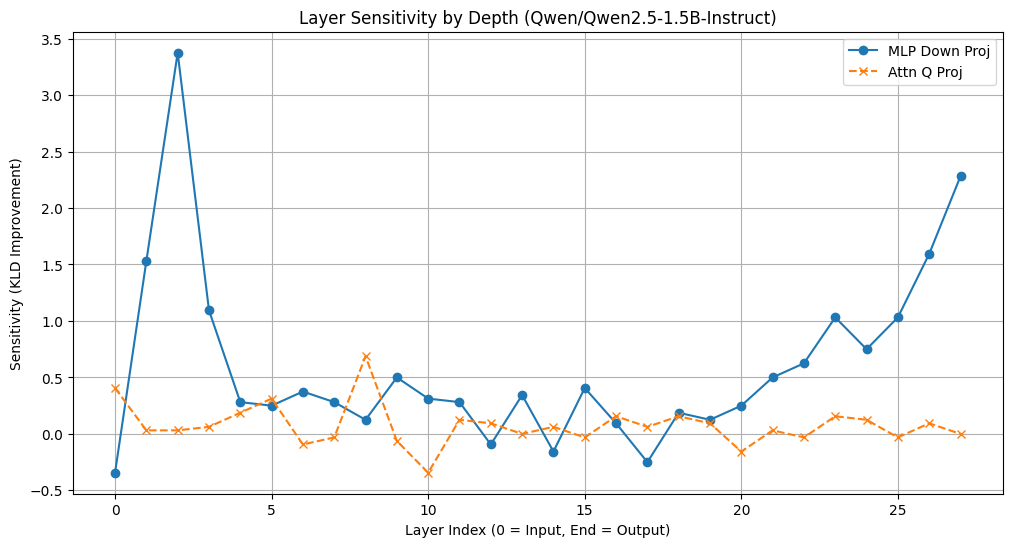

In [13]:
import matplotlib.pyplot as plt
import pandas as pd

# Convert to DataFrame for easy analysis
df_sensitivity = pd.DataFrame(list(sensitivity_map.items()), columns=['Layer_Name', 'KLD_Gain'])

# 1. Sort to find the "Top 10 Most Sensitive Layers"
top_10 = df_sensitivity.sort_values(by='KLD_Gain', ascending=False).head(10)
print("=== Top 10 Most Sensitive Layers ===")
print(top_10)

# 2. Extract Layer Patterns (Position vs. Type)
# Create columns for 'Layer_Index' and 'Module_Type'
df_sensitivity['Layer_Index'] = df_sensitivity['Layer_Name'].apply(lambda x: int(x.split('.')[2]) if 'layers' in x else -1)
df_sensitivity['Module_Type'] = df_sensitivity['Layer_Name'].apply(lambda x: x.split('.')[-1])

# 3. Visualization: Sensitivity by Position
plt.figure(figsize=(12, 6))
# Filter only for a specific module type to make the plot clean (e.g., down_proj)
subset = df_sensitivity[df_sensitivity['Module_Type'] == 'down_proj'].sort_values('Layer_Index')
plt.plot(subset['Layer_Index'], subset['KLD_Gain'], marker='o', label='MLP Down Proj')

# Add Q_proj for comparison
subset_q = df_sensitivity[df_sensitivity['Module_Type'] == 'q_proj'].sort_values('Layer_Index')
plt.plot(subset_q['Layer_Index'], subset_q['KLD_Gain'], marker='x', linestyle='--', label='Attn Q Proj')

plt.title(f"Layer Sensitivity by Depth ({CURRENT_MODEL_ID})")
plt.xlabel("Layer Index (0 = Input, End = Output)")
plt.ylabel("Sensitivity (KLD Improvement)")
plt.legend()
plt.grid(True)
plt.show()

In [14]:
# Experiment B: FP8 (Native) - Restoration Method
print(f"\n--- Starting Experiment B: FP8 {CURRENT_MODEL_ID} ---")

# 1. Define FP8 Wrapper (The "Quantized Layer")
class FP8LinearStorage(nn.Module):
    def __init__(self, original_linear):
        super().__init__()
        self.in_features = original_linear.in_features
        self.out_features = original_linear.out_features
        # Store compressed FP8 weights
        self.weight = nn.Parameter(original_linear.weight.data.to(torch.float8_e4m3fn), requires_grad=False)
        # Keep bias in BF16/FP32 for stability
        if original_linear.bias is not None:
            self.bias = nn.Parameter(original_linear.bias.data, requires_grad=False)
        else:
            self.register_parameter('bias', None)

    def forward(self, x):
        # On-the-fly dequantize to BF16 for computation
        return F.linear(x, self.weight.to(x.dtype), self.bias)

# 2. Helper: Convert BF16 Model to Global FP8
def convert_to_fp8_global(model, safe_layers={"lm_head"}):
    print("Converting model to Global FP8 (Storage)...")
    modules_to_wrap = []
    for name, module in model.named_modules():
        if isinstance(module, nn.Linear):
            if any(s in name for s in safe_layers):
                continue
            modules_to_wrap.append((name, module))

    for name, module in tqdm(modules_to_wrap, desc="Wrapping Layers"):
        parent_name = name.rsplit('.', 1)[0] if '.' in name else ''
        child_name = name.split('.')[-1]
        parent = model.get_submodule(parent_name) if parent_name else model
        setattr(parent, child_name, FP8LinearStorage(module))
        del module
    torch.cuda.empty_cache()
    return model

# 3. Helper: Profile Restoration Sensitivity (Specialized for FP8 Wrapper)
def profile_fp8_restoration_sensitivity(model_q, model_ref, calib_input):
    print("Profiling FP8 Restoration Sensitivity...")
    sensitivity = {}

    # Get Baseline Error (Global FP8 vs Reference)
    with torch.no_grad():
        ref_logits = model_ref(calib_input).logits
        base_logits = model_q(calib_input).logits
        base_kld = compute_kld(ref_logits, base_logits)

    # Identify all wrapper layers
    fp8_layers = [(n, m) for n, m in model_q.named_modules() if isinstance(m, FP8LinearStorage)]

    for name, module in tqdm(fp8_layers, desc="Profiling Layers"):
        # A. Swap to BF16 (Restoration)
        orig_layer = recursive_getattr(model_ref, name)
        # We temporarily replace the wrapper with the real Linear layer
        # (Simulating "What if we fix this layer?")

        # Create temp BF16 layer
        temp_linear = nn.Linear(orig_layer.in_features, orig_layer.out_features, bias=(orig_layer.bias is not None)).to(device, dtype=torch.float16)
        temp_linear.weight.data = orig_layer.weight.data
        if orig_layer.bias is not None:
            temp_linear.bias.data = orig_layer.bias.data

        # Swap IN
        recursive_setattr(model_q, name, temp_linear)

        # B. Measure New KLD
        with torch.no_grad():
            cur_logits = model_q(calib_input).logits
            cur_kld = compute_kld(ref_logits, cur_logits)

        # C. Score = How much did KLD drop? (Higher drop = More Sensitive)
        sensitivity[name] = base_kld - cur_kld

        # D. Swap BACK to FP8 Wrapper
        recursive_setattr(model_q, name, module)
        del temp_linear

    return sensitivity


--- Starting Experiment B: FP8 Qwen/Qwen2.5-1.5B-Instruct ---


In [15]:
# --- Main Execution ---

# A. Prepare Models
print("Loading BF16 Reference Model...")
model_fp16 = AutoModelForCausalLM.from_pretrained(CURRENT_MODEL_ID, torch_dtype=torch.float16, device_map="auto")

print("Creating FP8 Quantized Model...")
# We clone the structure first to avoid destroying the reference
model_fp8 = copy.deepcopy(model_fp16)
model_fp8 = convert_to_fp8_global(model_fp8)

# B. Profile
sensitivity_map = profile_fp8_restoration_sensitivity(
    model_q=model_fp8,
    model_ref=model_fp16,
    calib_input=calib_data # Assumes calib_data exists from previous cells
)
sorted_layers = sorted(sensitivity_map.items(), key=lambda x: x[1], reverse=True)
all_layer_names = [n for n, s in sorted_layers]

print("Moving Reference Model to CPU to free VRAM...")
model_fp16 = model_fp16.cpu()  # Offload to System RAM
torch.cuda.empty_cache()       # Clear GPU Memory

# C. Experiment Loop
sorted_thresholds = sorted(SENSITIVITY_THRESHOLDS)
current_restored_count = 0
#base_preds = None # Store baseline preds if needed

for threshold in sorted_thresholds:
    print(f"\nTargeting Threshold: {threshold:.0%} kept in BF16")

    # 1. Determine new layers to fix
    target_count = int(len(all_layer_names) * threshold)
    layers_to_fix_now = all_layer_names[current_restored_count : target_count]

    # 2. Perform Surgery (FP8 Wrapper -> BF16 Linear)
    if layers_to_fix_now:
        print(f"Restoring {len(layers_to_fix_now)} additional layers...")
        # We reuse the standard perform_surgery since it overwrites the module
        perform_surgery(model_fp8, layers_to_fix_now, model_fp16)
        current_restored_count = target_count
    else:
        print("No new layers to restore for this step.")

    # 3. WandB & Eval
    run = wandb.init(
        project=WANDB_PROJECT_NAME,
        name=f"{CURRENT_MODEL_ID.split('/')[-1]}-FP8-{threshold}",
        config={"model": CURRENT_MODEL_ID, "threshold": threshold, "method": "KLD-FP8"},
        reinit=True
    )

    acc, ppl, lat, static_mem, peak_mem, preds = evaluate_full_suite(
        model_fp8, tokenizer, mmlu_dataset, f"KLD-FP8-{threshold}"
    )

    flip = calculate_flip_rate(base_preds, preds)

    # 4. Log
    wandb.log({
        "Accuracy": acc, "Perplexity": ppl, "Latency": lat, "Static_Memory": static_mem,
        "Peak_Memory": peak_mem, "Flip_Rate": flip, "Threshold": threshold
    })

    results_table.append({
        "Model": CURRENT_MODEL_ID,
        "Method": "KLD-FP8",
        "Threshold": threshold,
        "Acc": acc,
        "Flip": flip,
        "PPL": ppl,
        "Latency": lat,
        "Static Mem": static_mem,
        "Peak Mem": peak_mem
    })

    run.finish()

# Cleanup
del model_fp8
del model_fp16
torch.cuda.empty_cache()
print("Experiment B Complete.")

Loading BF16 Reference Model...
Creating FP8 Quantized Model...
Converting model to Global FP8 (Storage)...


Wrapping Layers:   0%|          | 0/196 [00:00<?, ?it/s]

Profiling FP8 Restoration Sensitivity...


Profiling Layers:   0%|          | 0/196 [00:00<?, ?it/s]

Moving Reference Model to CPU to free VRAM...

Targeting Threshold: 0% kept in BF16
No new layers to restore for this step.


--- Evaluating: KLD-FP8-0.0 ---


MMLU Eval:   0%|          | 0/5000 [00:00<?, ?it/s]

Computing PPL:   0%|          | 0/3 [00:00<?, ?it/s]

Results -> Acc: 57.28%, PPL: 6.39, Latency: 1.91s, Static Mem: 1.73GB, Peak Mem: 1.75GB



Targeting Threshold: 5% kept in BF16
Restoring 9 additional layers...
Surgery: Replacing 9 Sensitive Layers with FP16...
Surgery Complete: 9 layers restored.


--- Evaluating: KLD-FP8-0.05 ---


MMLU Eval:   0%|          | 0/5000 [00:00<?, ?it/s]

Computing PPL:   0%|          | 0/3 [00:00<?, ?it/s]

Results -> Acc: 56.98%, PPL: 6.37, Latency: 1.88s, Static Mem: 1.83GB, Peak Mem: 1.86GB



Targeting Threshold: 10% kept in BF16
Restoring 10 additional layers...
Surgery: Replacing 10 Sensitive Layers with FP16...
Surgery Complete: 10 layers restored.


--- Evaluating: KLD-FP8-0.1 ---


MMLU Eval:   0%|          | 0/5000 [00:00<?, ?it/s]

Computing PPL:   0%|          | 0/3 [00:00<?, ?it/s]

Results -> Acc: 56.94%, PPL: 6.35, Latency: 1.89s, Static Mem: 1.94GB, Peak Mem: 1.97GB



Targeting Threshold: 20% kept in BF16
Restoring 20 additional layers...
Surgery: Replacing 20 Sensitive Layers with FP16...
Surgery Complete: 20 layers restored.


--- Evaluating: KLD-FP8-0.2 ---


MMLU Eval:   0%|          | 0/5000 [00:00<?, ?it/s]

Computing PPL:   0%|          | 0/3 [00:00<?, ?it/s]

Results -> Acc: 56.98%, PPL: 6.35, Latency: 1.91s, Static Mem: 2.11GB, Peak Mem: 2.14GB



Targeting Threshold: 30% kept in BF16
Restoring 19 additional layers...
Surgery: Replacing 19 Sensitive Layers with FP16...
Surgery Complete: 19 layers restored.


--- Evaluating: KLD-FP8-0.3 ---


MMLU Eval:   0%|          | 0/5000 [00:00<?, ?it/s]

Computing PPL:   0%|          | 0/3 [00:00<?, ?it/s]

Results -> Acc: 56.70%, PPL: 6.33, Latency: 1.83s, Static Mem: 2.22GB, Peak Mem: 2.25GB


Experiment B Complete.


# Visualization

                         Model         Method  Threshold     Acc    Flip  \
0   Qwen/Qwen2.5-1.5B-Instruct  FP16 Baseline       0.00  0.5734  0.0000   
1   Qwen/Qwen2.5-1.5B-Instruct        KLD-NF4       0.00  0.5366  0.2418   
2   Qwen/Qwen2.5-1.5B-Instruct        KLD-NF4       0.05  0.5298  0.2414   
3   Qwen/Qwen2.5-1.5B-Instruct        KLD-NF4       0.10  0.5308  0.2276   
4   Qwen/Qwen2.5-1.5B-Instruct        KLD-NF4       0.20  0.5474  0.1486   
5   Qwen/Qwen2.5-1.5B-Instruct        KLD-NF4       0.30  0.5544  0.1288   
6   Qwen/Qwen2.5-1.5B-Instruct        KLD-FP8       0.00  0.5728  0.0740   
7   Qwen/Qwen2.5-1.5B-Instruct        KLD-FP8       0.05  0.5698  0.0726   
8   Qwen/Qwen2.5-1.5B-Instruct        KLD-FP8       0.10  0.5694  0.0718   
9   Qwen/Qwen2.5-1.5B-Instruct        KLD-FP8       0.20  0.5698  0.0688   
10  Qwen/Qwen2.5-1.5B-Instruct        KLD-FP8       0.30  0.5670  0.0610   

         PPL   Latency  Static Mem  Peak Mem  
0   6.328403  1.870516    2.883327  2.89

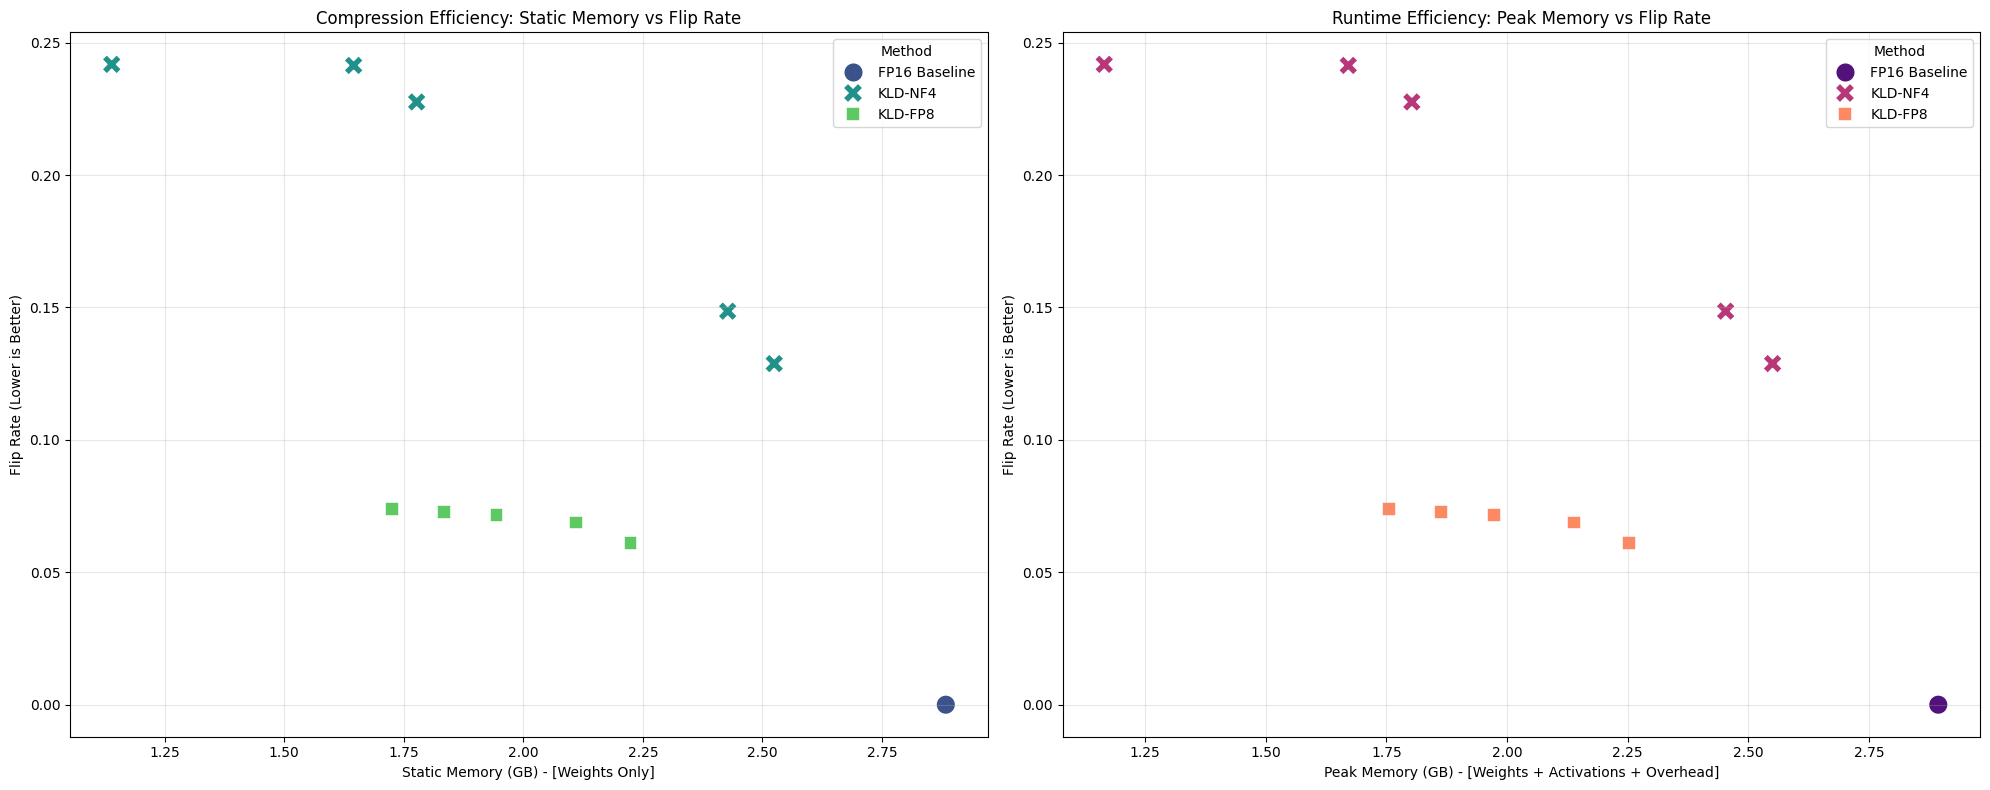

In [16]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Create DataFrame
df = pd.DataFrame(results_table)

# Display the data
print(df)

# 2. Set up the figure with 2 subplots (Static vs Peak)
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# --- Plot A: Static Memory (Model Size) vs Flip Rate ---
sns.scatterplot(
    data=df, x='Static Mem', y='Flip', hue='Method', style='Method',
    s=200, palette='viridis', ax=axes[0]
)
axes[0].set_title("Compression Efficiency: Static Memory vs Flip Rate")
axes[0].set_xlabel("Static Memory (GB) - [Weights Only]")
axes[0].set_ylabel("Flip Rate (Lower is Better)")
axes[0].grid(True, alpha=0.3)

# Add labels for Plot A
for i in range(df.shape[0]):
    row = df.iloc[i]
    # Check if 'Static_Mem' exists to avoid errors
    if 'Static_Mem' in row:
        axes[0].text(row.Static_Mem + 0.01, row.Flip + 0.001, f"{row.Threshold:.0%}", fontsize=9)

# --- Plot B: Peak Memory (Runtime Cost) vs Flip Rate ---
sns.scatterplot(
    data=df, x='Peak Mem', y='Flip', hue='Method', style='Method',
    s=200, palette='magma', ax=axes[1]
)
axes[1].set_title("Runtime Efficiency: Peak Memory vs Flip Rate")
axes[1].set_xlabel("Peak Memory (GB) - [Weights + Activations + Overhead]")
axes[1].set_ylabel("Flip Rate (Lower is Better)")
axes[1].grid(True, alpha=0.3)

# Add labels for Plot B
for i in range(df.shape[0]):
    row = df.iloc[i]
    if 'Peak_Mem' in row:
        axes[1].text(row.Peak_Mem + 0.05, row.Flip + 0.001, f"{row.Threshold:.0%}", fontsize=9)

plt.tight_layout()
plt.savefig("efficiency_frontier_comparison.png")
plt.show()

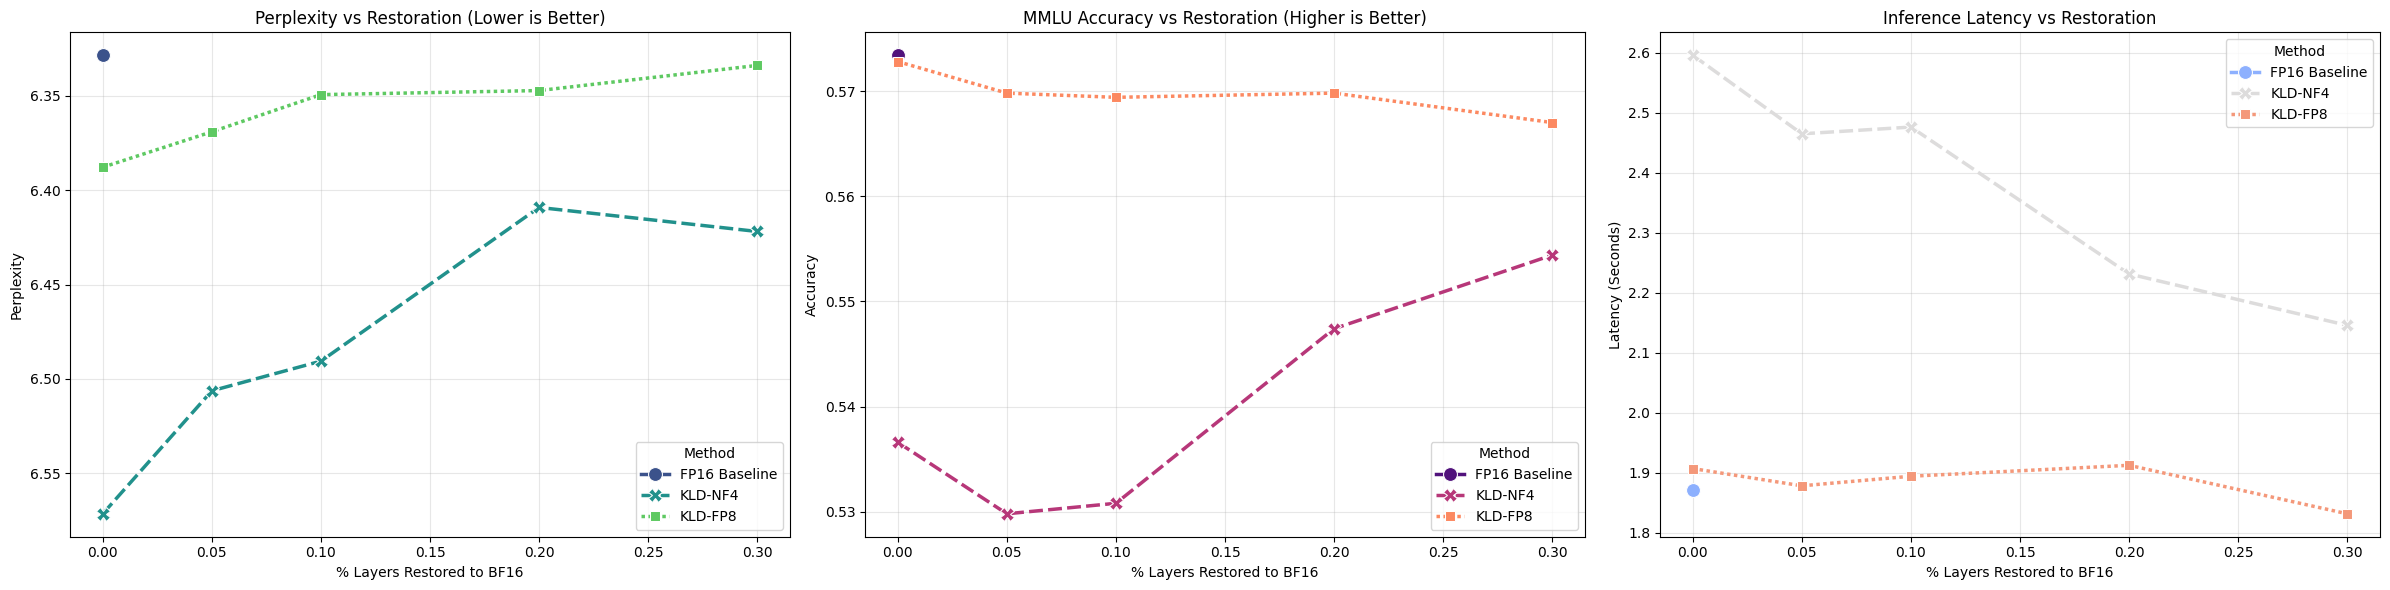

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure DataFrame is ready
df = pd.DataFrame(results_table)

# Set up the figure with 3 subplots side-by-side
fig, axes = plt.subplots(1, 3, figsize=(24, 6))

# --- Plot 1: Perplexity (Lower is Better) ---
sns.lineplot(
    data=df, x='Threshold', y='PPL', hue='Method', style='Method',
    markers=True, markersize=10, linewidth=2.5, ax=axes[0], palette='viridis'
)
axes[0].set_title("Perplexity vs Restoration (Lower is Better)")
axes[0].set_xlabel("% Layers Restored to BF16")
axes[0].set_ylabel("Perplexity")
axes[0].grid(True, alpha=0.3)
axes[0].invert_yaxis() # Optional: If you want 'better' (lower) to be higher up, remove if standard view preferred.

# --- Plot 2: Accuracy (Higher is Better) ---
sns.lineplot(
    data=df, x='Threshold', y='Acc', hue='Method', style='Method',
    markers=True, markersize=10, linewidth=2.5, ax=axes[1], palette='magma'
)
axes[1].set_title("MMLU Accuracy vs Restoration (Higher is Better)")
axes[1].set_xlabel("% Layers Restored to BF16")
axes[1].set_ylabel("Accuracy")
axes[1].grid(True, alpha=0.3)

# --- Plot 3: Latency (Lower is Better) ---
sns.lineplot(
    data=df, x='Threshold', y='Latency', hue='Method', style='Method',
    markers=True, markersize=10, linewidth=2.5, ax=axes[2], palette='coolwarm'
)
axes[2].set_title("Inference Latency vs Restoration")
axes[2].set_xlabel("% Layers Restored to BF16")
axes[2].set_ylabel("Latency (Seconds)")
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig("metrics_comparison.png")
plt.show()

In [20]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [21]:
import pandas as pd
import os
import shutil # Import shutil for copying files

# Define the directory to save files in Google Drive
save_dir = '/content/drive/MyDrive/Columbia-LLMSeminar/SLLM project/Mena/exp0_1'
os.makedirs(save_dir, exist_ok=True)

# Save results_table as CSV
df_results = pd.DataFrame(results_table)
df_results.to_csv(os.path.join(save_dir, 'exp0_1_results.csv'), index=False)
print(f"Results table saved to {os.path.join(save_dir, 'exp0_1_results.csv')}") # Corrected print statement

# Copy figures to Google Drive
figures_to_copy = [
    'efficiency_frontier_comparison.png',
    'metrics_comparison.png'
]

for fig_name in figures_to_copy:
    fig_path = os.path.join('/content', fig_name)
    if os.path.exists(fig_path):
        # Use shutil.copy2 to copy the file, then os.remove to delete the original
        shutil.copy2(fig_path, os.path.join(save_dir, fig_name))
        # os.remove(fig_path) # Remove original after copying
        print(f"Copied {fig_name} to {os.path.join(save_dir, fig_name)} and removed original.")
    else:
        print(f"Figure {fig_name} not found in current directory.")

Results table saved to /content/drive/MyDrive/Columbia-LLMSeminar/SLLM project/Mena/exp0_1/exp0_1_results.csv
Copied efficiency_frontier_comparison.png to /content/drive/MyDrive/Columbia-LLMSeminar/SLLM project/Mena/exp0_1/efficiency_frontier_comparison.png and removed original.
Copied metrics_comparison.png to /content/drive/MyDrive/Columbia-LLMSeminar/SLLM project/Mena/exp0_1/metrics_comparison.png and removed original.
